# Comparison of Dimension Reduction Models

In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import KernelPCA

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Lambda
from keras.models import Model

import matplotlib.pyplot as plt

2022-07-29 16:10:05.394292: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/home/matt/anaconda3/envs/phd/lib/libcudart.so.11.0:/home/matt/anaconda3/pkgs/cudatoolkit-11.4.1-h8ab8bb3_9/lib/libcudart.so.11.0:/usr/lib/cuda/lib64:
2022-07-29 16:10:05.394308: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Models Compared

In this notebook, we'll compare the results of several dimension reduction methods on the publication dataset from Scopus. The 7 methods compared are:
- Classical PCA
- Probabilistic PCA
- Poisson PCA
- Kernel PCA with Gaussian kernel
- 'Vanilla' autoencoder (1 or 2 hidden layers)
- Variational autoencoder (1 or 2 hidden layers)

We'll scale all count variables using $\log(x+1)$. For the Poisson PCA model, we'll include the continuous variables as `covariates` and assign them parameters in the GLM that defines the mapping to the lower dimensional space. For all other models, continuous variables will be used as-is.

The PCA models are all implemented in the `R` script `Comparison_of_PCA_models.r`. The results of that script are imported here.

The variational autoencoder used here is a simple adaptation of the one implemented by Ahmed Fawzy Gad [here](https://blog.paperspace.com/how-to-build-variational-autoencoder-keras/).

In [2]:
latent_dim = 2

df = pd.read_csv('../pca_inputs_standardized.csv')
data = df.values

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2230 entries, 0 to 2229
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   log_articles                 2230 non-null   float64
 1   log_publications             2230 non-null   float64
 2   log_openaccess               2230 non-null   float64
 3   log_coauthors                2230 non-null   float64
 4   log_first_author             2230 non-null   float64
 5   log_last_author              2230 non-null   float64
 6   log_citation_count           2230 non-null   float64
 7   log_cited_by_count           2230 non-null   float64
 8   log_h_index                  2230 non-null   float64
 9   log_growth_rate              2230 non-null   float64
 10  log_mean_citations_per_year  2230 non-null   float64
 11  log_mean_citations_per_doc   2230 non-null   float64
 12  log_SJR_mean                 2230 non-null   float64
 13  log_journal_h_inde

,log_articles,log_publications,log_openaccess,log_coauthors,log_first_author,log_last_author,log_citation_count,log_cited_by_count,log_h_index,log_growth_rate,log_mean_citations_per_year,log_mean_citations_per_doc,log_SJR_mean,log_journal_h_index_mean,log_author_count_mean,log_author_position_mean
0,-0.142826,0.021193,-1.286565,-0.659529,0.158489,0.030294,-0.626348,-0.858632,-0.576502,-0.505248,-0.525093,-1.340227,-1.676475,-2.686418,-1.086891,-0.840776
1,0.927539,1.127389,0.417764,0.207375,0.158489,1.411569,0.062534,0.007301,0.172755,0.387302,0.089591,-1.357293,-1.503030,-1.572050,-0.893377,-0.130266
2,0.386083,0.314658,0.341645,-0.765611,0.492465,0.601828,0.327838,0.304983,0.445461,-0.471868,0.060726,0.221973,0.330687,0.776250,-1.041525,-0.513666
3,1.078945,1.142599,1.177148,1.025826,0.547271,1.041295,1.091883,1.086574,1.278663,1.284458,0.989428,0.748114,0.370037,0.275377,0.976168,1.568230
4,-0.735052,-0.910231,-0.706585,-0.314863,-1.559550,-1.156486,-1.262919,-1.231163,-1.385635,-0.771071,-1.349822,-1.421549,0.315938,-0.314405,0.622270,-0.117670


# Kernel PCA Model

In [4]:
kpca = KernelPCA(n_components=latent_dim, kernel='rbf')
kpca_data = kpca.fit_transform(df)

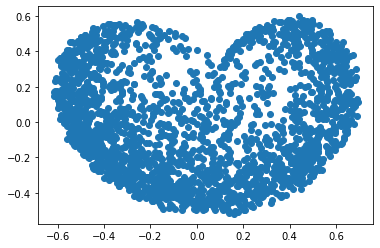

In [5]:
plt.scatter(kpca_data[:, 0], kpca_data[:, 1]);

In [10]:
df_kpca = pd.DataFrame(kpca_data, columns=['x', 'y'])
# df_kpca.to_excel('../results/kpca_mapped_points.xlsx', index=False)

In [15]:
scores = pd.read_csv('../results/pc1_scores_all_models.csv')
scores['KPCA_PC1'] = df_kpca['x']
scores.head()

,PCA_C_PC1,PCA_PC1,PLNPCA_PC1,AE1_dim1,AE2_dim1,KPCA_PC1
0,-2.070054,-2.560709,-1.734228,1.454233,-0.134096,0.424159
1,1.738389,1.496534,2.188704,3.139133,0.331870,-0.048366
2,1.080762,0.802431,1.103613,1.381669,0.855882,-0.122175
3,4.312466,4.934973,4.385583,0.601613,4.787392,-0.545785
4,-4.241595,-4.821242,-4.330958,0.339616,0.370561,0.570904


In [16]:
scores.corr()

,PCA_C_PC1,PCA_PC1,PLNPCA_PC1,AE1_dim1,AE2_dim1,KPCA_PC1
PCA_C_PC1,1.000000,0.996077,0.998430,0.303121,0.633258,-0.826204
PCA_PC1,0.996077,1.000000,0.994160,0.257876,0.668691,-0.828470
PLNPCA_PC1,0.998430,0.994160,1.000000,0.299425,0.617944,-0.809516
AE1_dim1,0.303121,0.257876,0.299425,1.000000,-0.242713,-0.273107
AE2_dim1,0.633258,0.668691,0.617944,-0.242713,1.000000,-0.614468
KPCA_PC1,-0.826204,-0.828470,-0.809516,-0.273107,-0.614468,1.000000


## Autoencoder Models

First, we construct the 'vanilla' autoencoders with 1 and 2 hidden layers, respectively. We'll use a simple stepped reduction of dimensions in our hidden layers. For example, in the encoder model with one hidden layer, we'll reduce to 5 dimensions in the hidden layer and then reduce to 2 dimensions in the output layer (with the reverse being true for the decoder model).

In [9]:
# autoencoder with 1 hidden layer
enc1_input = Input(shape=(16,), name='enc1_input')
enc1_hidden_layer = Dense(units=8, activation='relu', use_bias='True', bias_initializer='zeros', name='enc1_hidden_layer')(enc1_input)
encoded1 = Dense(units=latent_dim, name='enc1_output_layer')(enc1_hidden_layer)

enc1 = Model(enc1_input, encoded1, name='Encoder-1_hidden_layer')

dec1_hidden_layer = Dense(units=8, activation='relu', use_bias=True, bias_initializer='zeros', name='dec1_hidden_layer')(encoded1)
decoded1 = Dense(units=16, activation='relu', use_bias=True, bias_initializer='zeros', name='decoder1_output')(dec1_hidden_layer)

autoencoder1 = Model(enc1_input, decoded1, name='autoencoder1')

encoder1 = keras.Model(enc1_input, encoded1, name='encoder1')

autoencoder1.summary()

Model: "autoencoder1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc1_input (InputLayer)     [(None, 16)]              0         
                                                                 
 enc1_hidden_layer (Dense)   (None, 8)                 136       
                                                                 
 enc1_output_layer (Dense)   (None, 2)                 18        
                                                                 
 dec1_hidden_layer (Dense)   (None, 8)                 24        
                                                                 
 decoder1_output (Dense)     (None, 16)                144       
                                                                 
Total params: 322
Trainable params: 322
Non-trainable params: 0
_________________________________________________________________


In [10]:
autoencoder1.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder1.fit(data, data, batch_size=128, epochs=250, verbose=False)

70/70 [==============================] - 0s 423us/step


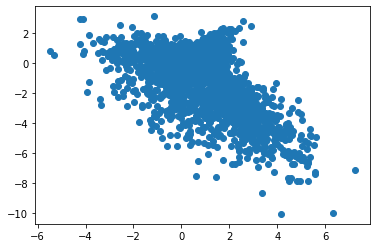

In [11]:
y1 = encoder1.predict(data)
plt.scatter(y1[:,0], y1[:,1]);

In [12]:
to_save = pd.DataFrame({'x': y1[:, 0], 'y': y1[:, 1]})
to_save.head()

,x,y
0,1.454233,0.011737
1,3.139133,-2.190091
2,1.381669,-0.722320
3,0.601613,-3.549023
4,0.339616,0.590188


In [13]:
to_save.to_csv('../results/ae_mapped_points.csv', index=False)

In [14]:
# autoencoder with 2 hidden layers
enc2_input = Input(shape=(16,), name='enc2_input')
enc2_hidden_layer1 = Dense(units=16, activation='relu', use_bias='True', bias_initializer='zeros', name='enc2_hidden_layer1')(enc2_input)
enc2_hidden_layer2 = Dense(units=8, activation='relu', use_bias='True', bias_initializer='zeros', name='enc2_hidden_layer2')(enc2_hidden_layer1)
encoded2 = Dense(units=latent_dim, name='enc2_output_layer')(enc2_hidden_layer2)

enc2 = Model(enc2_input, encoded2, name='Encoder-2_hidden_layer')

dec2_hidden_layer1 = Dense(units=8, activation='relu', use_bias=True, bias_initializer='zeros', name='dec2_hidden_layer1')(encoded2)
dec2_hidden_layer2 = Dense(units=16, activation='relu', use_bias=True, bias_initializer='zeros', name='dec2_hidden_layer2')(dec2_hidden_layer1)
decoded2 = Dense(units=16, activation='relu', use_bias=True, bias_initializer='zeros', name='decoder2_output')(dec2_hidden_layer2)

autoencoder2 = Model(enc2_input, decoded2, name='autoencoder2')

encoder2 = keras.Model(enc2_input, encoded2, name='encoder2')

autoencoder2.summary()

Model: "autoencoder2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc2_input (InputLayer)     [(None, 16)]              0         
                                                                 
 enc2_hidden_layer1 (Dense)  (None, 16)                272       
                                                                 
 enc2_hidden_layer2 (Dense)  (None, 8)                 136       
                                                                 
 enc2_output_layer (Dense)   (None, 2)                 18        
                                                                 
 dec2_hidden_layer1 (Dense)  (None, 8)                 24        
                                                                 
 dec2_hidden_layer2 (Dense)  (None, 16)                144       
                                                                 
 decoder2_output (Dense)     (None, 16)               

In [15]:
autoencoder2.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder2.fit(data, data, batch_size=128, epochs=250, verbose=False)

70/70 [==============================] - 0s 411us/step


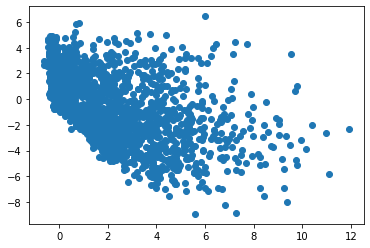

In [16]:
y2 = encoder2.predict(data)
plt.scatter(y2[:,0], y2[:,1]);

In [32]:
to_save2 = pd.DataFrame({'x': y2[:, 0], 'y': y2[:, 1]})
to_save2.to_csv('../results/ae2_mapped_points.csv', index=False)

## Variational Autoencoder Models

In [51]:
# Encoder with 1 hidden layer
encoder_input = Input(shape=(17,), name="encoder_input")

encoder_hidden_layer1 = Dense(units=17, activation='relu', use_bias=True, bias_initializer='zeros', name='encoder_hidden_layer1')(encoder_input)
encoder_hidden_layer2 = Dense(units=5, activation='relu', use_bias=True, bias_initializer='zeros', name='encoder_hidden_layer2')(encoder_hidden_layer1)
encoder_mu = Dense(units=latent_dim, activation='relu', name='encoder_mu')(encoder_hidden_layer2)
encoder_log_variance = Dense(units=latent_dim, name='encoder_log_variance')(encoder_hidden_layer2)

encoder_mu_log_var_model = Model(encoder_input, (encoder_mu, encoder_log_variance), name="encoder_mu_log_var_model")

def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = tf.keras.backend.random_normal(shape=tf.keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + tf.keras.backend.exp(log_variance/2) * epsilon
    # tf.print(random_sample[0])
    return random_sample

encoder_output = Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

encoder = Model(encoder_input, encoder_output, name="encoder_model")
encoder.summary()

Model: "encoder_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 17)]         0           []                               
                                                                                                  
 encoder_hidden_layer1 (Dense)  (None, 17)           306         ['encoder_input[0][0]']          
                                                                                                  
 encoder_hidden_layer2 (Dense)  (None, 5)            90          ['encoder_hidden_layer1[0][0]']  
                                                                                                  
 encoder_mu (Dense)             (None, 2)            12          ['encoder_hidden_layer2[0][0]']  
                                                                                      

In [52]:
# Decoder with 1 hidden layer
decoder_input = Input(shape=latent_dim, name="decoder_input")

decoder_hidden_layer1 = Dense(units=5, activation='relu', name='decoder_hidden_layer1')(decoder_input)
decoder_hidden_layer2 = Dense(units=4500, activation='relu', name='decoder_hidden_layer2')(decoder_hidden_layer1)
decoder_output = Dense(units=17, activation='relu', name='decoder_output')(decoder_hidden_layer2)

decoder = Model(decoder_input, decoder_output, name="decoder_model")
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_hidden_layer1 (Dens  (None, 5)                15        
 e)                                                              
                                                                 
 decoder_hidden_layer2 (Dens  (None, 4500)             27000     
 e)                                                              
                                                                 
 decoder_output (Dense)      (None, 17)                76517     
                                                                 
Total params: 103,532
Trainable params: 103,532
Non-trainable params: 0
_________________________________________________________________


In [53]:
vae_input = Input(shape=(17,), name="VAE_input")
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = Model(vae_input, vae_decoder_output, name="VAE")
vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 VAE_input (InputLayer)      [(None, 17)]              0         
                                                                 
 encoder_model (Functional)  (None, 2)                 420       
                                                                 
 decoder_model (Functional)  (None, 17)                103532    
                                                                 
Total params: 103,952
Trainable params: 103,952
Non-trainable params: 0
_________________________________________________________________


In [54]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 0.0005
        # tf.print(y_predict)
        reconstruction_loss = tf.keras.backend.mean(tf.keras.backend.square(y_true-y_predict))
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance))
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance))
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [55]:
vae.compile(optimizer=tf.keras.optimizers.Adam(), loss=loss_func(encoder_mu, encoder_log_variance))

In [56]:
vae.fit(data, data, epochs=50, batch_size=128, shuffle=True)

Epoch 1/50
18/18 [==============================] - 0s 2ms/step - loss: nan
Epoch 2/50
18/18 [==============================] - 0s 3ms/step - loss: nan
Epoch 3/50
18/18 [==============================] - 0s 3ms/step - loss: nan
Epoch 4/50
18/18 [==============================] - 0s 3ms/step - loss: nan
Epoch 5/50
18/18 [==============================] - 0s 2ms/step - loss: nan
Epoch 6/50
18/18 [==============================] - 0s 3ms/step - loss: nan
Epoch 7/50
18/18 [==============================] - 0s 3ms/step - loss: nan
Epoch 8/50
18/18 [==============================] - 0s 2ms/step - loss: nan
Epoch 9/50
18/18 [==============================] - 0s 2ms/step - loss: nan
Epoch 10/50
18/18 [==============================] - 0s 3ms/step - loss: nan
Epoch 11/50
18/18 [==============================] - 0s 4ms/step - loss: nan
Epoch 12/50
18/18 [==============================] - 0s 3ms/step - loss: nan
Epoch 13/50
18/18 [==============================] - 0s 3ms/step - loss: nan
Epoch 14

70/70 [==============================] - 0s 443us/step


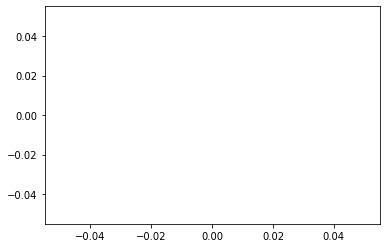

In [57]:
y = encoder.predict(data)
plt.scatter(y[:,0], y[:,1]);